In [3]:
# evaluate mlp for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [7]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch = config
    [24, 500, 100, 100]
    # prepare data
	data = series_to_supervised(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	# define model
	model = Sequential()
	model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape(1, n_input)
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return [error,predictions]

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=5):
	# fit and evaluate the model n times
    scores = []
    predictions = []
    for _ in range(n_repeats):
        tmp_scores, tmp_predictions = walk_forward_validation(data, n_test, config)
        scores.append(tmp_scores)
        predictions.append(tmp_predictions)
    return [scores,predictions]

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()


In [27]:
def find_best_solution(series,name,method="nn"):
    data = series.values
    n_test = int(len(data)*0.2) # percentage used for test
    config = [24, 500, 100, 100]
    scores,predictions = repeat_evaluate(data, config, n_test)
    summarize_scores('mlp', scores)
    plt.savefig("scores_%s_%s.png" % (name,method))
    plt.show()
    train,test = train_test_split(data,n_test)
    prediction = pd.DataFrame(list(train.flatten())+np.array(predictions[0]).flatten().tolist())
    ax = pd.DataFrame(data).plot(label="Original") # main data
    prediction.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig("pred_%s_%s.png" %(name,method))
    plt.show()

# Female births

 > 6.716
 > 6.662
 > 6.698
 > 6.623
 > 6.958
mlp: 6.732 RMSE (+/- 0.118)


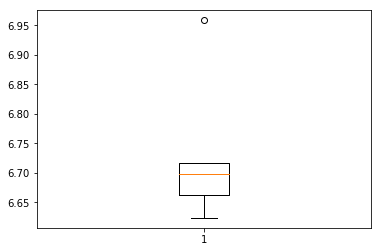

<Figure size 432x288 with 0 Axes>

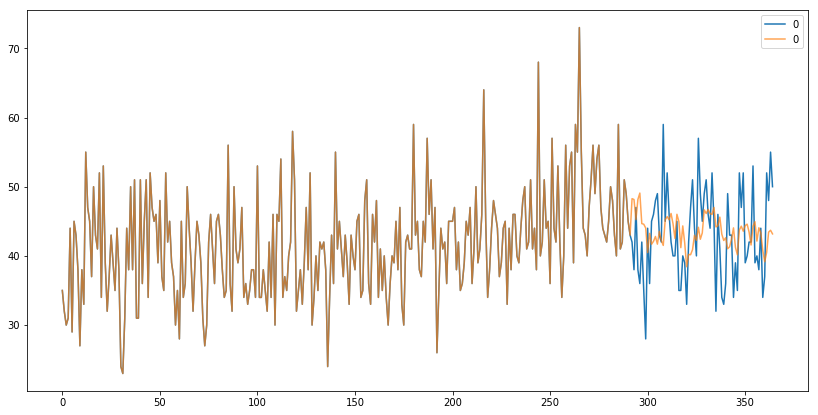

In [31]:
series = pd.read_csv('daily-total-female-births.csv', header=0,index_col=0)
find_best_solution(series,"births")

# Sampoo sales

 > 120.285
 > 113.633
 > 126.398
 > 117.296
 > 102.114
mlp: 115.945 RMSE (+/- 8.082)


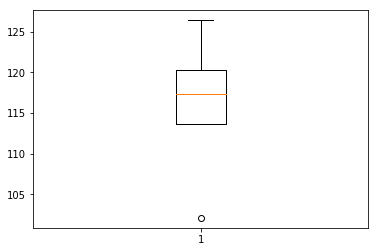

<Figure size 432x288 with 0 Axes>

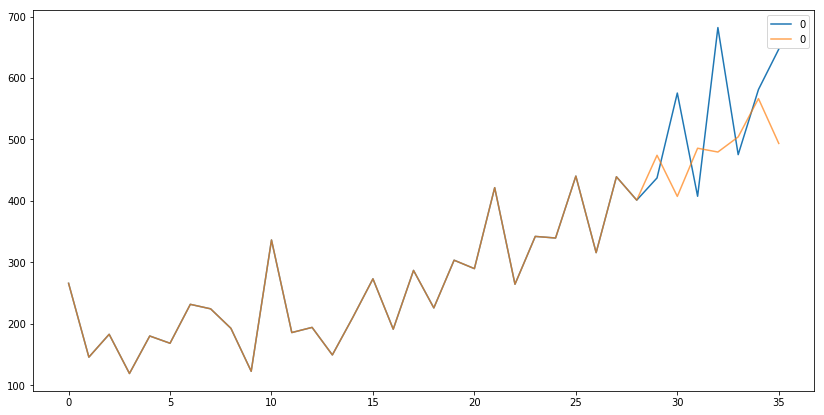

In [32]:
series = pd.read_csv('shampoo.csv', header=0, index_col=0)
find_best_solution(series,"shampoo")

 > 2.186
 > 2.300
 > 2.163
 > 2.327
 > 2.181
mlp: 2.231 RMSE (+/- 0.068)


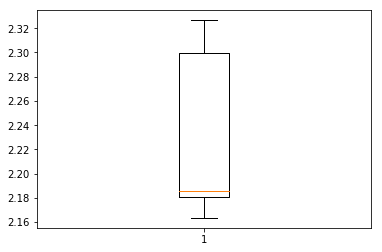

<Figure size 432x288 with 0 Axes>

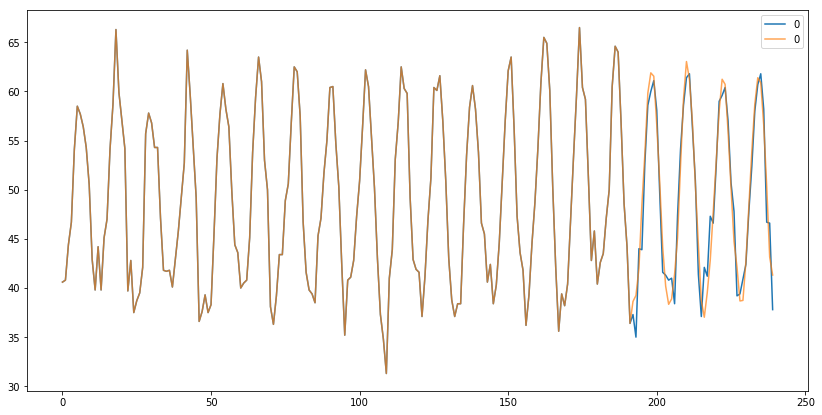

In [36]:
series = pd.read_csv('monthly-mean-temp.csv', header=0,parse_dates=["Month"],index_col=0)
find_best_solution(series,"temp")


# Car sales

 > 2128.115
 > 2231.766
 > 2154.737
 > 2027.224
 > 1914.313
mlp: 2091.231 RMSE (+/- 110.037)


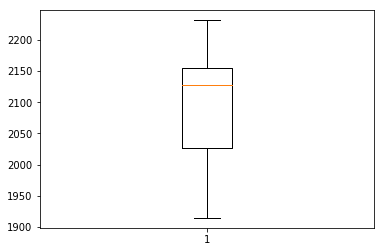

<Figure size 432x288 with 0 Axes>

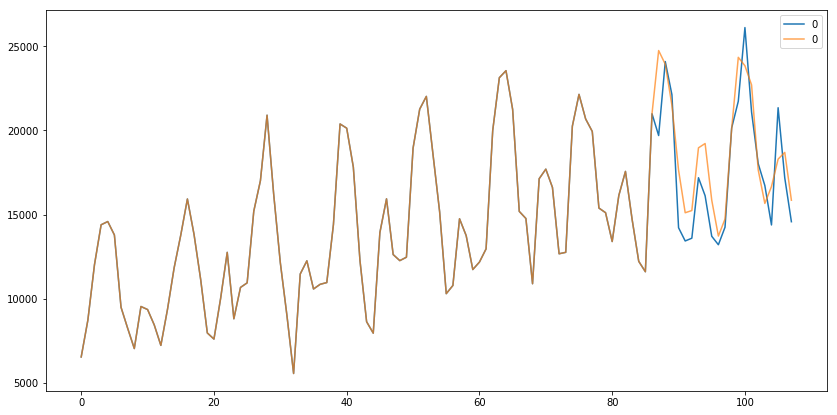

In [28]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
find_best_solution(series,"cars")

 > 2013.029
 > 2122.559
 > 1789.750
 > 2180.757
 > 2181.096
mlp: 2057.438 RMSE (+/- 147.220)


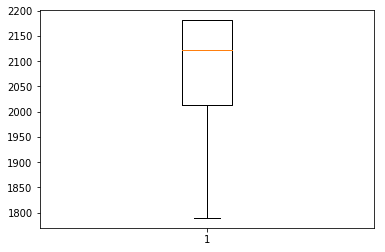

In [22]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = int(len(data)*0.2) # percentage used for test


# define config
#config = [24, 500, 100, 100]
config = [[24, 500, 100, 100],[12, 500, 100, 100]]

# grid search
scores,predictions = repeat_evaluate(data, config[0], n_test)
# summarize scores
summarize_scores('mlp', scores)

# Show Predictions

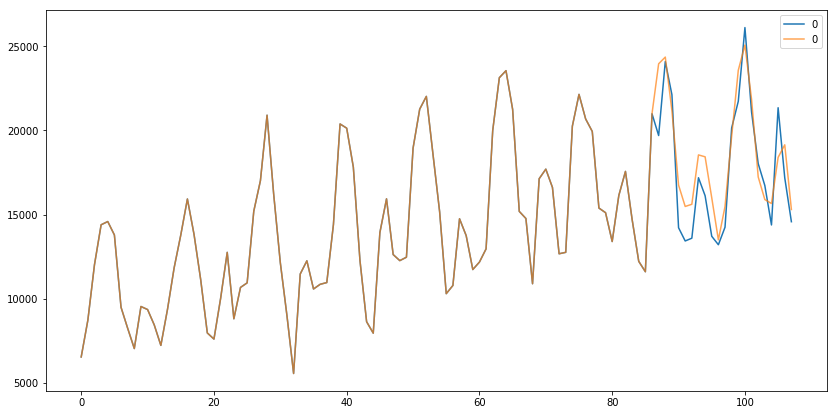

In [40]:
train,test = train_test_split(data,n_test)
prediction = pd.DataFrame(list(train.flatten())+np.array(predictions[0]).flatten().tolist())
ax = pd.DataFrame(data).plot(label="Original") # main data
prediction.plot(ax=ax, alpha=.7, figsize=(14,7))
plt.show()